# Figure out what makes good sleep

The purpose of this analysis is to determine what factors, as measured by my fitbit charge hr (version 1, not the new fancy one), contribute to good sleep. 

Please note that this won't all be done in chronological order. If I complete the whole thing, then come back and do some visualisations at the beginning, I won't rewrite later parts to make sense. Keep that in mind. 

In [1]:
# IMPORT ALL THE THINGS!
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from xgboost import XGBRegressor
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
fitbit_v1_data_file_path = '../input/dataInCsvFormat/fitbitDataV1.csv'
fitbit_v1_data = pd.read_csv(fitbit_v1_data_file_path)

# fitbit_v1_data.describe()
fitbit_v1_data.columns

Index(['date', 'totalMinutesAsleep', 'totalSleepRecords', 'totalTimeInBed',
       'steps', 'lightlyActiveMinutes', 'fairlyActiveMinutes',
       'veryActiveMinutes', 'caloriesOut', 'activityCalories', 'caloriesBMR',
       'marginalCalories', 'totalDistance', 'veryActiveDistance',
       'moderatelyActiveDistance', 'lightlyActiveDistance', 'elevation',
       'floors', 'restingHeartRate', 'heartRateZoneOutOfRangeMinutes',
       'heartRateZoneOutOfRangeCaloriesOut', 'heartRateZoneFatBurnMinutes',
       'heartRateZoneFatBurnCaloriesOut', 'heartRateZoneCardioMinutes',
       'heartRateZoneCardioCaloriesOut', 'heartRateZonePeakMinutes',
       'heartRateZonePeakCaloriesOut'],
      dtype='object')

Wow, apparently the minimum calories I expend each day just being alive is 1679. And my mean caloriesOut per day is 3030! Go me! Cool. 

In [3]:
train_column_names = fitbit_v1_data.columns.drop('date').drop('totalMinutesAsleep').drop('totalSleepRecords').drop('totalTimeInBed')
X = fitbit_v1_data[train_column_names]
y = fitbit_v1_data.totalMinutesAsleep

OK so I have my X and y sets

In [4]:
def getTestTrainSplits(X, y):
    return train_test_split(X, y, test_size=0.3, train_size=0.7)
xTrain, xTest, yTrain, yTest = getTestTrainSplits(X, y)

And I've got some train/test split. I find that any test is worth doing on different randomly selected train/test splits, so I've made a function to neaten that up a bit in later code, and also called it to provide a train/test split that is available to use as I code things. 

Now I'll check to see what a good `max_depth` is for this dataset. I've just left `n_estimators=200` because that's a good large number and gradient boosting doesn't overfit super easily. 

In [5]:
xTrain, xTest, yTrain, yTest = getTestTrainSplits(X, y)
for d in [3,4,5,6,7,8,9]:
    tuning_gbr = GradientBoostingRegressor(n_estimators=200, max_depth=d, random_state=0)
    tuning_gbr.fit(xTrain, yTrain)
    tuning_predictions = tuning_gbr.predict(xTest)
    print("max_depth="+str(d)+", mae="+str(mean_absolute_error(yTest, tuning_predictions)))

max_depth=3, mae=81.34382185977046
max_depth=4, mae=80.86450001799292
max_depth=5, mae=79.2052786276595
max_depth=6, mae=78.92843431598361
max_depth=7, mae=76.93788660256023
max_depth=8, mae=81.24744986809978
max_depth=9, mae=79.66885525884366


OK so the results vary between (very occasionally) 60 and (occasionally) 100, mostly around the 70-90 range. Is that good? Well no because we're talking in minutes here and an accuracy of plus/minus AN HOUR AND A HALF is useless when that's 18.75%~20% of desired sleep time. 

I'll try with `max_leaf_nodes` and see what that does. 

In [6]:
xTrain, xTest, yTrain, yTest = getTestTrainSplits(X, y)
for l in [5, 25, 50, 250, 500, 2500, 5000]:
    tuning_gbr = GradientBoostingRegressor(n_estimators=200, max_depth=5, max_leaf_nodes=l, random_state=0)
    tuning_gbr.fit(xTrain, yTrain)
    tuning_predictions = tuning_gbr.predict(xTest)
    print("max_leaf_nodes="+str(l)+"\t\tmea="+str(mean_absolute_error(yTest, tuning_predictions)))

max_leaf_nodes=5		mea=81.11411635989076
max_leaf_nodes=25		mea=84.88584062161725
max_leaf_nodes=50		mea=85.09279631832646
max_leaf_nodes=250		mea=84.99009380999799
max_leaf_nodes=500		mea=84.99009380999799
max_leaf_nodes=2500		mea=84.99009380999799
max_leaf_nodes=5000		mea=84.99009380999799


`max_leaf_nodes=50` comes out best most of the times I run this. 

I would be using other methods here, but I'm restricting myself to those that are easy to make graphs of how different features affect the target variable because the objective of this analysis is to _determine what factors contribute to good sleep_. 

I will use `GradientBoostingRegressor` with `n_estimators=200` and `max_depth=6` and `max_leaf_nodes=50` and see what `plot_partial_dependence` shows me. 

[0.04329701 0.06922756 0.04852845 0.04639328 0.04433844 0.04685502
 0.01053923 0.04309595 0.03825329 0.06127308 0.05271077 0.06615172
 0.02855235 0.02803866 0.03457047 0.0712693  0.08498284 0.04497822
 0.07338845 0.01376758 0.03004024 0.00626658 0.01348155]


/home/chhk/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


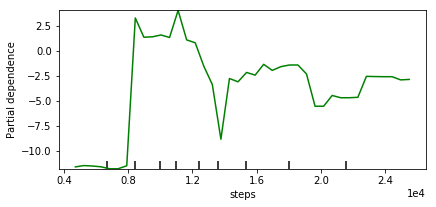

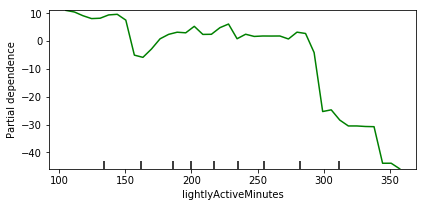

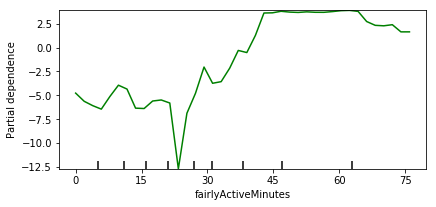

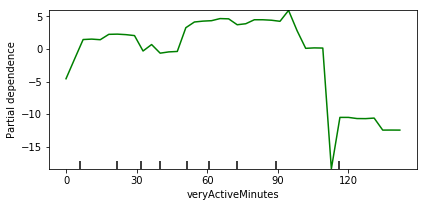

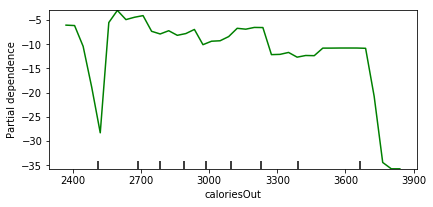

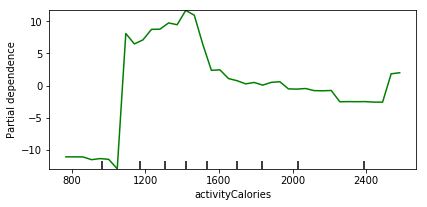

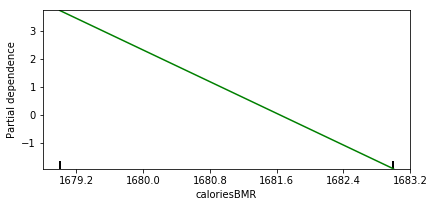

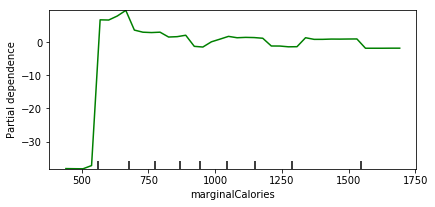

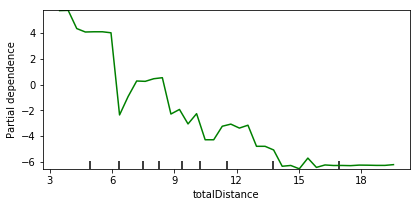

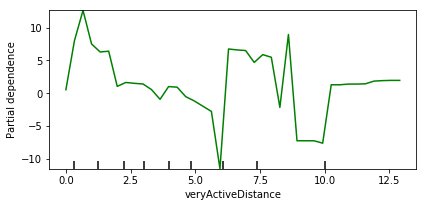

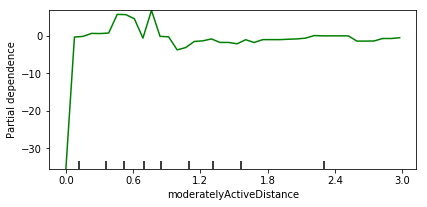

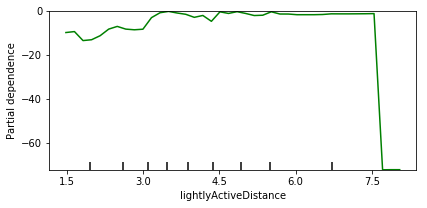

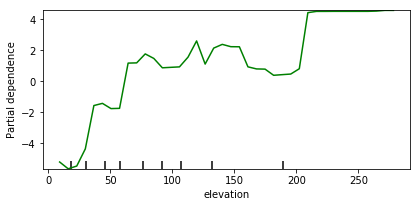

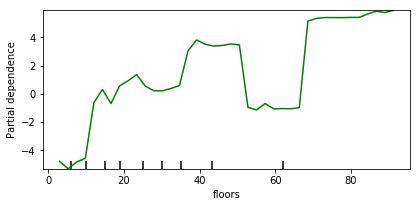

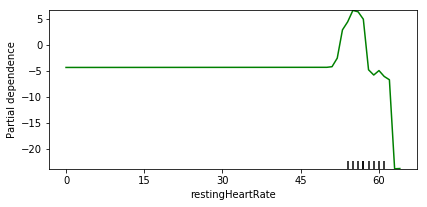

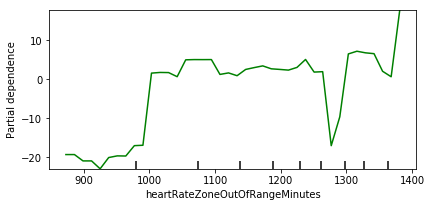

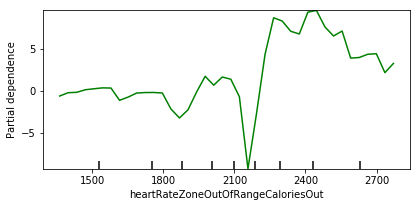

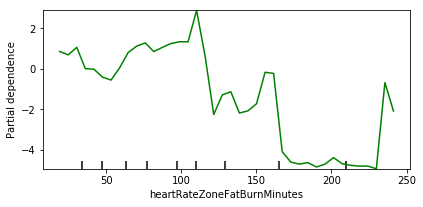

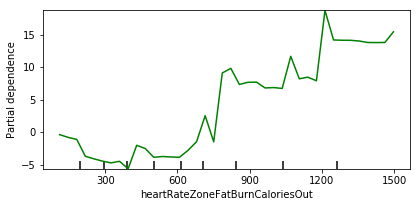

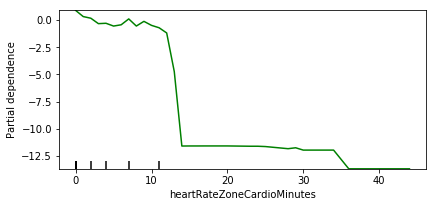

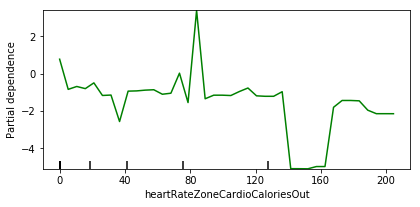

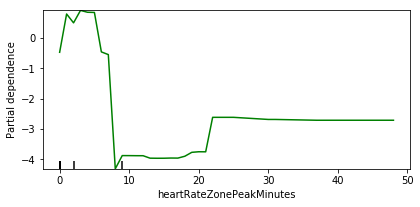

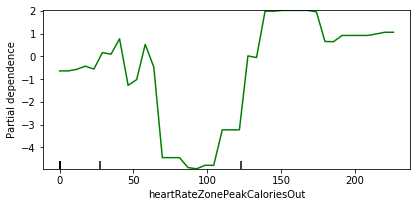

In [7]:
gbr = GradientBoostingRegressor(n_estimators=200, max_depth=6, max_leaf_nodes=50)
gbr.fit(X, y)
print(gbr.feature_importances_)
for f in range(len(train_column_names)):
    plot = plot_partial_dependence(gbr, features=[f], X=X, feature_names=train_column_names, grid_resolution=40)
    

Well that's a lot of graphs, I guess I'll look through and see which tell me useful things. 
* Steps: up to ~10,000 it seems have an effect on sleep, past ~11,000 and it drops of into the steep negatives. That's unexpected - I predicted a linear(ish) relationship here. 
* Lightly active minutes: Other than a strange blip around 160, sleep minutes appear to be related to lightly active minutes up until about ~280 - after that it is not a useful predictor for sleep. 
* Fairly active minutes: sleep isn't dependent on this unless a minimum of ~40 minutes has been achieved. 
* Very active minutes: as I thought, very active minutes has a very strong effect on sleep. 
* Calories out: unexpectedly, sleep has little dependence on overall calorie expenditure. 
* Activity calories: the number of calories expended in activities is shown to have a massive effect on sleep. 
* Calories BMR: Basically how many you burn just by existing - I don't think this is of any use at all, given that it only varies by 3 calories and I can't control it. 
* Marginal calories: this mostly has a strong effect on sleep only when it's between ~600 and ~850. 
* Total distance: total distances effect on sleep is only meaningful up to about 8 KM. 
* Very active distance: a very variable graph - perhaps I require some outlier clean up in my data - which shows that it has a strong effect most of the time. 
* Moderately active distance: little effect past about 0.8 KM. 
* Lightly active distance: has little effect on sleep. 
* Elevation: at low levels (0~75) has no effect, after that has huge effects on sleep. Apparently hills matter. 
* Floors: after 10 and besides a strange blip later on, floors have a meaningful effect on sleep. 
* Resting heart rate: has an effect on sleep, thought given how small the range of values for resting heart rate is, and how little control I have over it in a single day, perhaps it's useless for this. 
* Heart rate zone out of range minutes: this is how much time I have a normal heart rate, and it's got a strong effect on sleep. 
* Heart rate zone out of range calories out: not so meaningful until the higher numbers, then it becomes very meaningful. 
* Heart rate zone fat burn minutes: very variable graph, but the first two hours of fat burn appear to have some meaningful effect on sleep, but not consistently. 
* Heart rate zone fat burn calories out: very meaningful _after_ ~800 calories. 
* Heart rate zone cardio minutes: very low effect on sleep minutes. 
* Heart rate zone cardio calories out: a highly variable graph that shows little dependence on this for sleep minutes. 
* Heart rate zone peak minutes: little to no effect - unexpected. I thought hard exercise would help with sleep. 
* Heart rate zone peak calories out: inconsistent, until about 120 calories after which it becomes extremely effective. 

Keep in mind that the heart rate tracking of the fitbit over ~125 is absolutely atrocious. Maybe higher heart rate data effect is so variable due to this. 

So, some things have a very strong effect, some have a very weak effect, some are super variable. I should look at some correlation graphs, and for that I need to go learn how to do cool graphs brb. 